# Table of contents
1. [Introduction + Background](#introduction)
    1. [Load Libraries](#introduction_0)
    2. [Define Global Utility Functions](#introduction_1)
    3. [Load Data Files](#introduction_2)
    4. [Set Global Plotting Parameters](#introduction_3)
2. [Properties of Whole-Brain and the corresponding Hemispheric participation coefficients are dissimilar](#section_0)
    1. [Section Specific Utility + Plotting Functions](#section_0_0)
    2. [Load data files and set variables](#section_0_1)
    3. [Analyses](#section_0_2)
3. [Hemispheric participation coefficients significantly predict the functional correlation between homotopic regional pairs](#section_1)
    1. [Section Specific Utility + Plotting Functions](#section_1_0)
    2. [Load data files and set variables](#section_1_1)
    3. [Analyses](#section_1_2)
4. [Hemispheric participation coefficient can significantly predict scores on the Math but not the Story task](#section_2)
    1. [Section Specific Utility + Plotting Functions](#section_2_0)
    2. [Multilayer Perceptron Parameters](#section_2_1)
    3. [Load data files and set variables](#section_2_2)
    4. [Analyses](#section_2_3)
5. [Summary](#summary)
6. [Trash](#trash)


# Introduction + Background <a name="introduction"></a>

The subsequent analyses, part of my Ph.D. thesis, aimed to explore the impact of inter-hemispheric connections on long-term recovery post brain injury. It is grounded on the assumption that lesioned areas with abundant inter-hemispheric connections have a higher probability of recovery, the investigation centered on the compensatory mechanism through the recruitment of homotopic region. Homotopic regions in our symmetrical brain refer to regions in opposite hemispheres found in the mirrored location. These regions, which form a homotopic pair, often share connections and functionalities with other areas, thus being an ideal candidate for facilitating compensation post-injury.

Using network-based evaluations, I investigated the connectional attributes of homotopic areas. The goal was to identify potential connection patterns that fosters the complex interactions underlying compensation after injury. Therefore, the thesis was exploratory in nature and explored several other metrics (e.g. degree) not included below. Here, I concentrate just on the 'participation coefficient,' a measure quantifying the diversity of connections a specific region has. Diversity, in this context, is understood as the distribution of connections across different groups of regions. In other words, participation coefficients identifies regions that integrate information across various groups and act as conduits for inter-group information transfer. As such, regions with high participation coefficients are integral to mediating information traffic throughout the brain. 

However, the original version of the participation coefficient doesn't exclusively focus on inter-hemispheric connections, but on all connections instead. To spotlight inter-hemispheric interactions, the calculation of the participation coefficient was adapted. I modified the calculate to isolate inter-hemispheric connections, to identify regions that demonstrate the greatest loss in connection diversity as a result of the absence of inter-hemispheric connections. The modified coefficient, known as the hemispheric (Hm) coefficient, was analyzed alongside the original, unmodified coefficient, termed the whole-brain (WB) coefficient. This notebook covers analyses meant to validate the modified Hm coefficient's capability to reflect the laterality between the hemispheres.

The Hm coefficient, created to capture a region's degree of inter-hemispheric connectivity, should ideally reflect significant properties that enable communication between the hemispheres. If not, the metrics used to evaluate connections would be useless in exploring any inter-hemispheric interactions. The goal was to validate the Hm coefficient as a reliable and accurate measure of inter-hemispheric connectivity, which is important for understanding brain recovery post-injury. The analyses began with an exploration of basic physiological properties, shifting focus to more cognitive properties later. Although not shown in this jupyter notebook, the findings from these analyses played a role in guiding subsequent explorations.


Extracting the connections from fMRI scans can be a extremely complex process, so I've opted to omit any preprocessing steps on the 'raw' data in this notebook. Raw being the image files obtained from the fMRI scanner. Instead, I'll be starting with a 246 x 246 connection matrix that I've already processed. This matrix consists of 246 cortical regions of interest along both the rows and columns. Each entry represents the streamline counts or an estimate of the axonal density connecting the two regions. See the plot  below to see the streamline counts. Sorry it's gigantic! Please note the sparsity of the streamlines. This is intentional as many of the measurements used in graph studies are more effective with sparse connections.

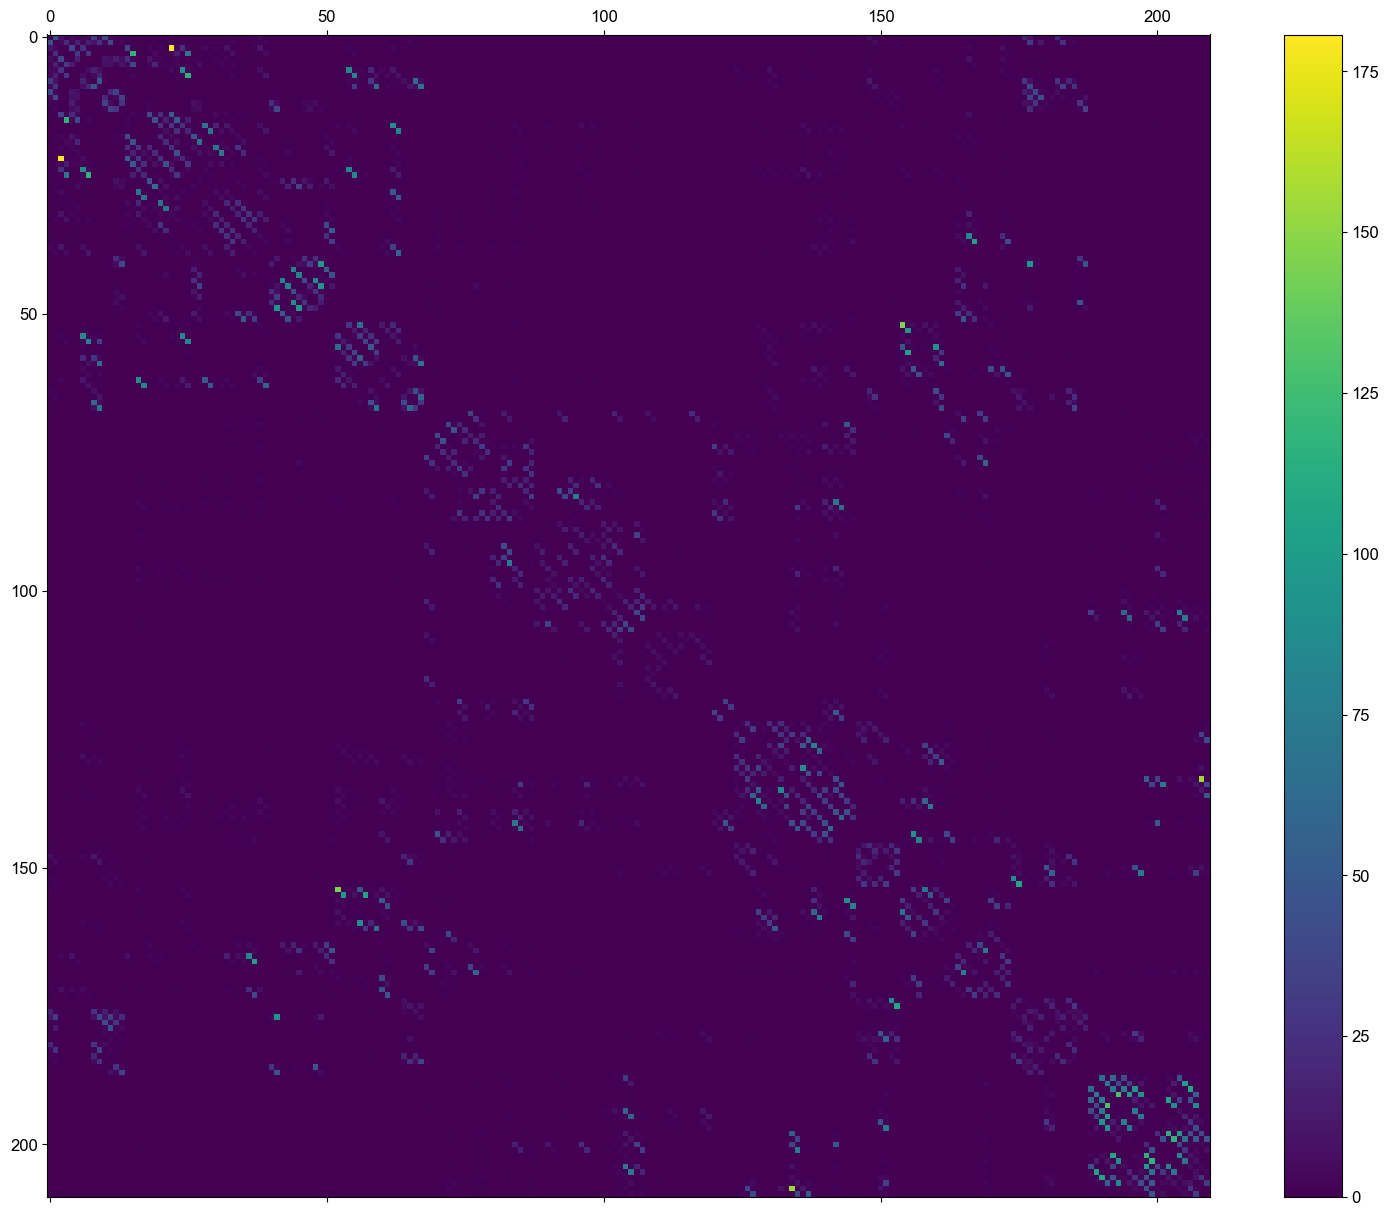

In [76]:
f = plt.figure(figsize=(19, 15))
plt.matshow(white_matter, fignum=f.number)
cb = plt.colorbar()

Also, due to the substantial amount of code involved in these analyses, I've tried to bury as much as possible within functions. Hopefully this helps streamlines the readability of the notebook. Each function comes with a short description of its functionality.

### Load Libraries <a name="introduction_0"></a>

In [50]:
import os
import re
import copy
import pickle
from itertools import compress

from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scipy.io import savemat, loadmat

import networkx as nx
import infomap

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nilearn.image import load_img, new_img_like
import nilearn.plotting as plotting
import hcp_utils as hcp

from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.evaluate import permutation_test

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")


### Define Global Utility Functions <a name="introduction_1"></a>

In [78]:
def odds(l):
    return [x for x in l if x & 1]

def even(l):
    return [x for x in l if not x & 1]

# Load various fMRI specific files
def load_nii_to_array(path):
    return load_img(path).get_fdata()

# Load various fMRI specific files
def read_gifti_label(file_path):
    gifti_label = nib.load(file_path)
    return np.array([x.data for x in gifti_label.darrays][0]).astype(float)

# Load various fMRI specific files
def update_gifti_label(data, gifti_label):
    for parcels, val in enumerate(data):
        gifti_label[gifti_label == parcels + 1] = val
    return gifti_label

# Converts numpy array to a networkx graph
def build_graphs(white_matter):
    G = {
        'b_hemisphere': nx.convert_matrix.from_numpy_array(white_matter),
        'l_hemisphere': nx.convert_matrix.from_numpy_array(white_matter),
        'r_hemisphere': nx.convert_matrix.from_numpy_array(white_matter)
    }
    node_range = range(np.shape(white_matter)[0])
    G['l_hemisphere'].remove_nodes_from(node for node in node_range if node % 2 == 1)
    G['r_hemisphere'].remove_nodes_from(node for node in node_range if node % 2 == 0)
    return G


### Load Data Files <a name="introduction_2"></a>

In [14]:
os.chdir('/Users/seonghahcho/Library/CloudStorage/Dropbox/HKU/HCP_matlab/lateralization/Python/')

subjects = open('./s900_unrelated.txt').read().splitlines()[:97]

connectome = loadmat('./BN_MRtrix3_98_15.mat')
m_connectome, g_connectome = connectome['m_connectome'], connectome['g_connectome']


### Set Global Plotting Parameters <a name="introduction_3"></a>

In [15]:
# Define font properties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

# Define math text properties
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'sans'
plt.rcParams['mathtext.it'] = 'sans:italic'
plt.rcParams['mathtext.default'] = 'it'

# Define sizes for different elements
small_size = 12
medium_size = 16
large_size = 20

plt.rc('font', size = small_size)          # controls default text sizes
plt.rc('axes', titlesize = small_size)     # fontsize of the axes title
plt.rc('axes', labelsize = medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize = small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize = small_size)    # legend fontsize
plt.rc('figure', titlesize = large_size)   # fontsize of the figure title

# Properties of Whole-Brain and the corresponding Hemispheric participation coefficients are dissimilar <a name="section_0"></a>

This section pertains to the 'Exploratory Data Analysis' aspect of my research, where I focus on visualizing the properties of the Hemispheric (Hm) coefficients and comparing them against the Whole-Brain (WB) coefficients. These preliminary analyses are crucial since Hm coefficients are derived from the WB coefficients, which could result in shared characteristics or similarities between the two. This could potentially influencing subsequent findings and their interpretations. Hence, a recurrent theme across all following analyses is the consistent implementation of analyses to both Hm and WB coefficients, and the subsequent comparisons thereof.

Additionally, this section includes other analyses intended to understand key regions as determined by the Hm and WB coefficients. These key regions, or hub nodes, exert a substantial influence on the pathways through which information traverses the brain and have been associated with other cognitive properties in individuals. Thus, focusing on hub nodes provides another clear window into the similarities and dissimilarities between the two coefficients.

### Section Specific Utility + Plotting Functions <a name="section_0_0"></a>

In [16]:
# Calculates the participation coefficient
def participation_coefficient(W, ci, degree = 'undirected'):
    if degree == 'in':
        W = W.T

    _, ci = np.unique(ci, return_inverse=True)
    ci += 1
    
    n = len(W)  # number of vertices
    Ko = np.sum(W, axis = 1)  # (out) degree
    Gc = np.dot((W != 0), np.diag(ci))  # neighbor community affiliation
    Kc2 = np.zeros((n,))  # community-specific neighbors

    for i in range(1, int(np.max(ci)) + 1):
        Kc2 += np.square(np.sum(W * (Gc == i), axis=1))

    P = np.ones((n,)) - Kc2 / np.square(Ko)
    # P=0 if for nodes with no (out) neighbors
    P[np.where(np.logical_not(Ko))] = 0

    return P

# Calculates the modules using the infomap algorithm
def infomap_partitions(G, white_matter):
    
    partition = np.zeros(G.number_of_nodes(), dtype=int)

    infomap_wrapper = infomap.Infomap("--two-level --silent")

    for e in G.edges(data=True):
        infomap_wrapper.addLink(*e[0:2], e[2].get('weight', 1))

    infomap_wrapper.run()

    for node, module in infomap_wrapper.modules:
        partition[node] = module

    modules = {}
    communities = []

    for node in G.nodes():
        module = partition[node]
        if module not in modules:
            modules[module] = []
        modules[module].append(node)

    for module_nodes in modules.values():
        communities.append(set(module_nodes))

    participation = np.array(list(participation_coefficient(white_matter, partition)))

    return modules, communities, participation, partition

# Calculated the modified participation coefficient
def calculate_lateral_participation_coefficient(white_matter, return_number = 210):
    G = {'b_hemisphere' : nx.convert_matrix.from_numpy_array(white_matter)}
    l_hemisphere, r_hemisphere = white_matter.copy(), white_matter.copy()
    l_hemisphere[1::2, :], l_hemisphere[:, 1::2] = 0, 0
    r_hemisphere[::2, :], r_hemisphere[:, ::2] = 0, 0

    partition = infomap_partitions(G['b_hemisphere'], white_matter)[3]
    
    b_participation, l_participation, r_participation = participation_coefficient(white_matter, partition), participation_coefficient(l_hemisphere, partition), participation_coefficient(r_hemisphere, partition)

    normal_indices, lateral_indices = b_participation.copy(), (b_participation - l_participation - r_participation).copy()

    sorted_indices = lambda indices: sorted(range(len(indices)), key = indices.__getitem__)

    return normal_indices, lateral_indices, sort_indices(normal_indices, return_number), sort_indices(lateral_indices, return_number)

In [17]:
# Sets some plotting settings related to the 3D mesh
def create_mesh_settings(left_gifti, right_gifti):
    return [{'mesh': hcp.mesh.inflated_left, 'roi_map': left_gifti, 'hemi': 'left', 'bg_map': hcp.mesh.sulc_left},
            {'mesh': hcp.mesh.inflated_left, 'roi_map': left_gifti, 'hemi': 'left', 'bg_map': hcp.mesh.sulc_left},
            {'mesh': hcp.mesh.inflated_right, 'roi_map': right_gifti, 'hemi': 'right', 'bg_map': hcp.mesh.sulc_right},
            {'mesh': hcp.mesh.inflated_right, 'roi_map': right_gifti, 'hemi': 'right', 'bg_map': hcp.mesh.sulc_right}]

# Plots a graph using force-directed drawing
def draw_graph(data, G, regions, ax):
    pos = nx.spring_layout(G, k = 0.25, weight = 'weight', seed = 14000)
    edgecolors = ['tab:blue'] * 68 + ['tab:orange'] * 56 + ['tab:green'] * 38 + ['tab:red'] * 12 + ['tab:purple'] * 14 + ['tab:brown'] * 22
    cmap = copy.copy(plt.get_cmap('viridis'))
    cmap.set_under('ivory')
    G_wghts = [G[u][v]['weight'] for u,v in G.edges()]

    nx.draw_networkx(G, pos, node_size=200, width=np.multiply(G_wghts, 0.25), edge_color='gray', node_color=data, cmap=cmap, labels=regions, font_size=36, font_weight='bold', font_family='Arial', ax=ax, vmin=np.percentile(data, 80))

    nx.draw_networkx_nodes(G, pos, node_size=200, node_color=data, cmap=cmap, ax=ax, vmin=np.percentile(data, 80), linewidths=2, edgecolors=edgecolors)

# Plots the surface together with the graph
def plot_surfaces_with_networks(data, connectome, regions, title):
    l_gifti_label = read_gifti_label('../../MRtrix3_connectome/BN_Atlas_freesurfer/fsaverage/32k/fsaverage.L.BN_Atlas.32k_fs_LR.label.gii')
    r_gifti_label = read_gifti_label('../../MRtrix3_connectome/BN_Atlas_freesurfer/fsaverage/32k/fsaverage.R.BN_Atlas.32k_fs_LR.label.gii')

    l_gifti_label = update_gifti_label(data, l_gifti_label)
    r_gifti_label = update_gifti_label(data, r_gifti_label)

    fig, axs = plt.subplots(4, 2, figsize = (9, 18))
    fig.subplots_adjust(hspace = 0.0001, wspace = 0.0001)
    axs = axs.ravel()

    mesh_settings = create_mesh_settings(l_gifti_label, r_gifti_label)
    view_settings = ['lateral', 'medial', 'medial', 'lateral']

    for subplot, (mesh_setting, view) in enumerate(zip(mesh_settings, view_settings)):
        ax = axs[subplot]
        ax.remove()
        ax = fig.add_subplot(4, 2, subplot + 1, projection = '3d')
        cmap = plt.get_cmap('viridis')
        cmap.set_under('dimgray')

        plotting.plot_surf_roi(surf_mesh=mesh_setting['mesh'], roi_map=mesh_setting['roi_map'], hemi=mesh_setting['hemi'], view=view, bg_map=mesh_setting['bg_map'], bg_on_data=True, darkness=.2, cmap=cmap, axes=ax, colorbar=True, cbar_tick_format='%f', vmin=min(data[data > 0]), vmax=max(data))

    ax = plt.subplot2grid(shape=(4, 2), loc=(2, 0), rowspan=2, colspan=2)
    connectome[connectome < np.percentile(connectome, 95)] = 0
    G = nx.convert_matrix.from_numpy_array(connectome)
    
    filter_regions = [data > np.percentile(data, 80)]
    filter_regions = list(compress(range(len(data)), filter_regions[0]))
    regions = {key: regions[key] for key in filter_regions}

    draw_graph(data, G, regions, ax)
    ax.axis("off")
    plt.show()

def add_significance_bars(axes, p_value, network):
    y, h = 12., 0.25
    x = network
    axes.plot([x - 0.25, x - 0.25, x + 0.25, x + 0.25], [y, y + h, y + h, y], lw = 2, c = 'k')
    axes.text(x, y + h, "*", ha = 'center', va = 'bottom', fontsize = 16, fontweight = 'bold', color = 'k')


### Load data files and set variables <a name="section_0_1"></a>

In [18]:
unformat_regions = open('./region_labels.txt').read().splitlines()
regions = {i * 2: re.sub('\s+', '', region) for i, region in enumerate(unformat_regions)}
regions.update({i * 2 + 1: re.sub('\s+', '', region) for i, region in enumerate(unformat_regions)})

parcellation = load_nii_to_array('./BN_Atlas_246_2mm.nii')

networks = loadmat('./label_index.mat')['label_index']
network_indices = [np.where(networks == network)[0] for network in np.arange(1, 8, 1)]

network_names = ['Dorsal Attention', 'Ventral Attention', 'Limbic', 'Frontoparietal', 'Default', 'Somatomotor', 'Visual']
network_abbrev = ['DAN', 'VAN', 'SAN', 'FPN', 'DMN', 'Som', 'Vis']

centers = np.genfromtxt('./centers.txt', delimiter='\t', usecols=(1, 2, 3))

with open('./individual_participation_coefficient.pkl', 'rb') as fp:
    individual_participation_coefficient = pickle.load(fp)

individual_participation_coef = {}
individual_participation_coef['normal'] = individual_participation_coefficient['normals']['participation']
individual_participation_coef['lateral'] = individual_participation_coefficient['lateral']['participation']


## Analyses <a name="section_0_2"></a>

Both Hm and WB coefficients are calculated using the connection matrix ```white_matter```. This matrix consists of the streamlines counts connecting two regions. In order to calculate the Hm and WB coefficients, the regions need to be group according to their connections. Groupings or modules are estimated using the infomap algorithm. This algorithm has been well-validated for grouping together regions.

In [19]:
participation_coef = {'normal': None, 'lateral': None}

white_matter = m_connectome

participation_coef['normal'], participation_coef['lateral'], _, _, = calculate_lateral_participation_coefficient(white_matter)

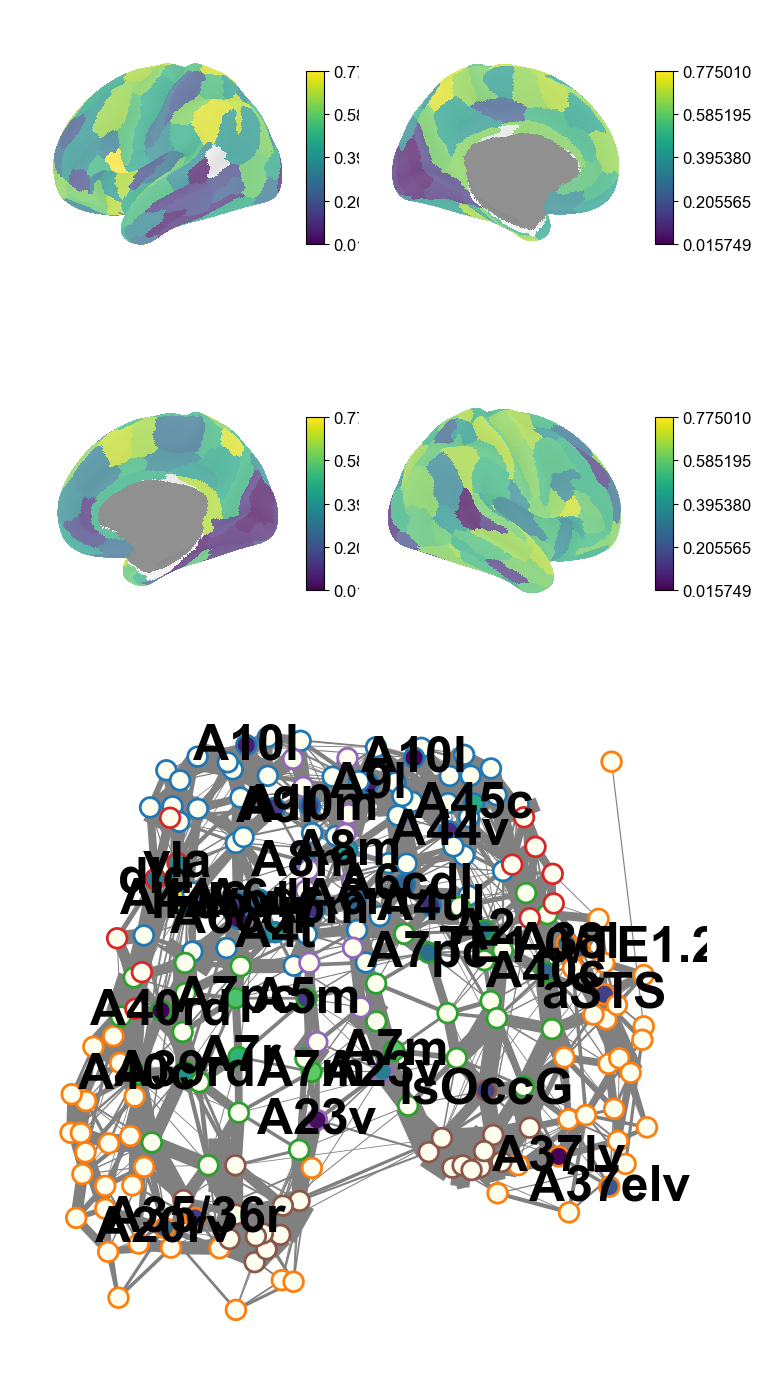

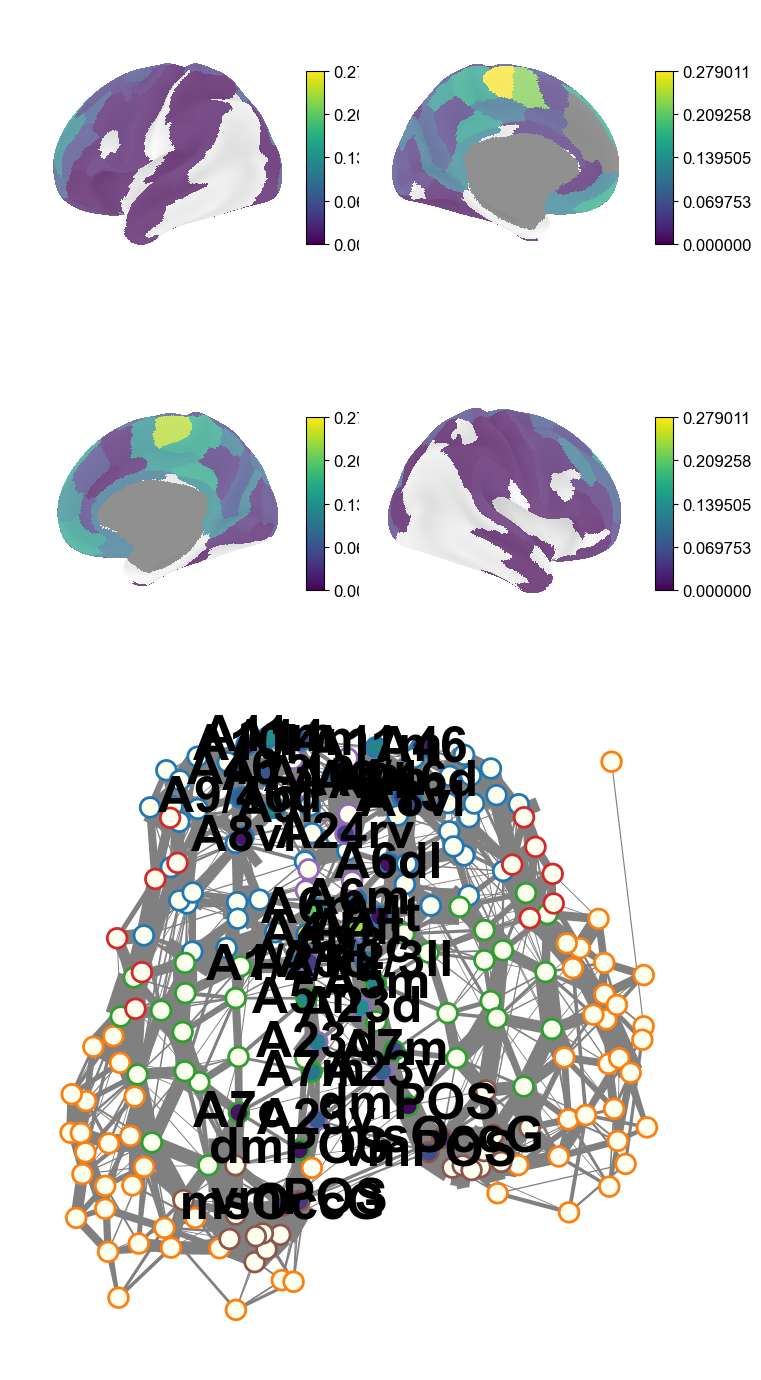

In [20]:
plot_surfaces_with_networks(participation_coef['normal'], copy.deepcopy(m_connectome), copy.deepcopy(regions), 'Participation Coefficient - Hemispheric')
plot_surfaces_with_networks(participation_coef['lateral'], copy.deepcopy(m_connectome), copy.deepcopy(regions), 'Participation Coefficient - Whole-Brain')

Hm and WB coefficients are projected onto the cortical surface and colored according the coefficient value. White surfaces do not have any connections useful for calculating the coefficients. Grayed out surfaces do not contain cell bodies starting and ending the axonal connections. Below the surface plots is the graph plot where each node corresponds to a region. The line thickness indicates connection strength and the node outline color indicates module. Nodes that are colored in are the highest ranking, most important nodes defined by either the Hm and WB coefficients. 

Some things to note:

+ The important Hm and WB regions have distinct distributions across the cortex. Hm regions are localized around the midline separating the two hemispheres. WB regions are distribution more uniformly through each hemisphere.
+ The strongest connections are found within a hemisphere than across the hemispheres.
+ The important Hm and WB regions are not uniformly distributed across modules. Some modules contain more important regions compared to other modules. 

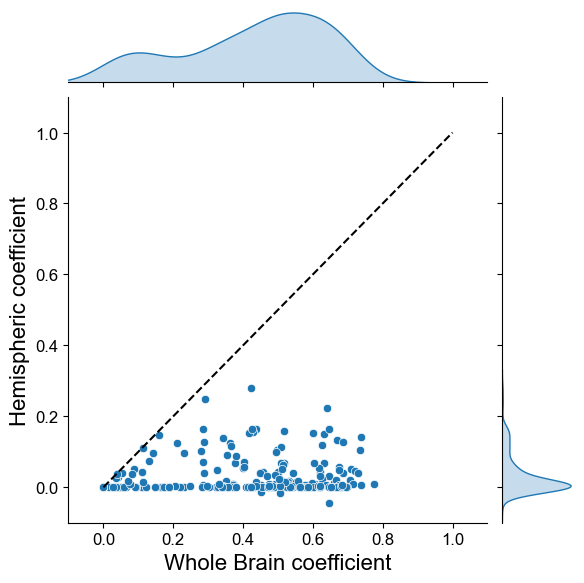

In [21]:
df = pd.DataFrame({
    'Whole-Brain': participation_coef['normal'],
    'Hemispheric': participation_coef['lateral']
})

plot = sns.jointplot(data=df, x='Whole-Brain', y='Hemispheric', fill=True, kind='kde', 
                     joint_kws={'alpha': 0}, legend=False,
                     xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

plot.plot_joint(sns.scatterplot)

plot.ax_joint.set_xlabel('Whole Brain coefficient')
plot.ax_joint.set_ylabel('Hemispheric coefficient')

limits = [max(*plot.ax_joint.get_xlim(), *plot.ax_joint.get_ylim()), min(*plot.ax_joint.get_xlim(), *plot.ax_joint.get_ylim())]
plot.ax_joint.plot([0,1], [0,1], '--k')


In [22]:
scipy.stats.pearsonr(participation_coef['normal'], participation_coef['lateral'])

PearsonRResult(statistic=0.05949326570070372, pvalue=0.3910285866251792)

The Hm and WB coefficients for eacg region is plotted against each other in a scatter plot to see if a trend exists. It appears that no clear relationship exists as important Hm coefficients are distributed uniformly across the WB coefficients. This is further support by running a simple Pearson's correlation and finding a non-significant outcome.

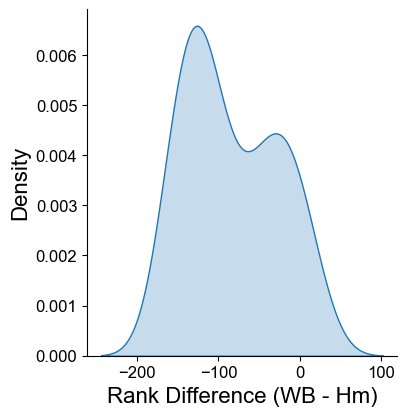

In [23]:
sorted_normal = np.argsort(participation_coef['normal'])
sorted_lateral = np.argsort(participation_coef['lateral'])

difference = np.array([np.where(sorted_normal == rank)[0][0] - np.where(sorted_lateral == rank)[0][0] for rank in range(210)])

sliced_difference = difference.flatten()[sorted_lateral[-42:]]

df = pd.DataFrame(data={'Rank Difference': sliced_difference, 'Measure': ['Participation'] * 42})

plt.figure(figsize=(4, 4.5))
plot = sns.kdeplot(data=df, x='Rank Difference', fill=True)
sns.despine()

plot.set_xlabel('Rank Difference (WB - Hm)')
plot.set_ylabel('Density')
plt.show()

In [24]:
scipy.stats.wilcoxon(sliced_difference)

WilcoxonResult(statistic=14.5, pvalue=5.002220859751105e-11)

I've previously mention a bit about important regions defined by Hm and WB coefficients but didn't explain why we care. Node importance has been found to correlate significantly with long-term outcomes. Lesions to important nodes result to greater deficits to behavior. Comparing the relative importance of nodes between Hm and WB coefficients offers another means of understanding how properties like importance shift between Hm and WB coefficients. Comparisons are conducted by simply taking the difference between the Hm and WB coefficient rank for each nodes

Here I test if the rankings difference distribution significantly differs from the null distribution centered on 0. If there is overall no change in rankings then it would be expected that the distributed should also be centered on 0. Using the Wilcoxon signed rank test shows that there is a significant difference in rankings for each regions between Hm and WB coefficients. 

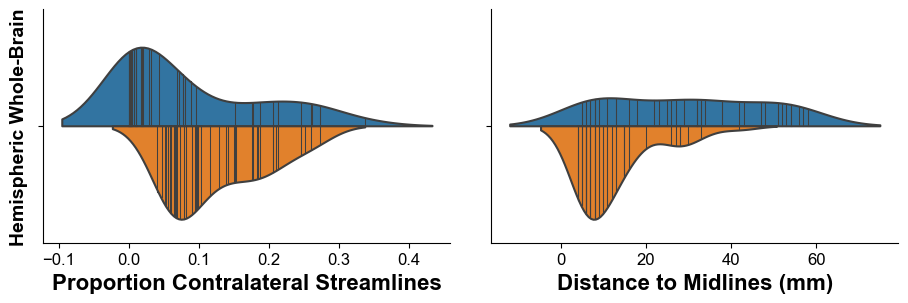

In [25]:
midline = np.abs(centers[:, 0])
contralateral_indices = [np.arange(1, 210, 2), np.arange(0, 210, 2)]
prop_contralateral = [np.sum(m_connectome[node, contralateral_indices[node%2]]) / np.sum(m_connectome[node]) for node in range(210)]

normal_data = np.squeeze(prop_contralateral)[np.squeeze(sorted_normal[-42:])]
lateral_data = np.squeeze(prop_contralateral)[np.squeeze(sorted_lateral[-42:])]
midline_normal_data = np.squeeze(midline)[np.squeeze(sorted_normal[-42:])]
midline_lateral_data = np.squeeze(midline)[np.squeeze(sorted_lateral[-42:])]

data = np.concatenate([normal_data, lateral_data, midline_normal_data, midline_lateral_data])

hubs = pd.DataFrame({
    'data': data, 
    'Measure': ['Participation'] * 168,
    'Shift': ['Proportion Contralateral'] * 84 + ['Distance to Midline'] * 84,
    'Laterality': ['Whole Brain'] * 42 + ['Hemispheric'] * 42 + ['Whole Brain'] * 42 + ['Hemispheric'] * 42
})

plot = sns.catplot(
    y="Measure", 
    x="data", 
    hue="Laterality", 
    col="Shift",
    kind="violin", 
    inner="stick", 
    split=True,
    data=hubs, 
    sharex=False
)

plot.fig.set_size_inches(12, 3)
plt.subplots_adjust(wspace=0.1)
plot._legend.remove()

for ax in plot.axes.flat:
    ax.set_xlabel('Proportion Contralateral Streamlines' if 'Proportion' in ax.get_title() else 'Distance to Midlines (mm)', fontweight='bold')
    ax.set_title('')
    # ax.spines['left'].set_visible(False)
    ax.set_yticklabels('', fontweight='bold')
    ax.set_ylabel('Hemispheric Whole-Brain', fontsize = 14, fontweight='bold')
    # ax.tick_params(axis='y', which='both', length=0)


In [26]:
print('Contralateral\n', scipy.stats.ranksums(normal_data, lateral_data, alternative = 'less'))
print('\nMidline\n', scipy.stats.ranksums(midline_normal_data, midline_lateral_data, alternative = 'greater'))

Contralateral
 RanksumsResult(statistic=-3.032714781112367, pvalue=0.0012118227736979614)

Midline
 RanksumsResult(statistic=4.307528516535707, pvalue=8.254440871936529e-06)


We extend our analyses to the spatial properties of important Hm and WB regions. Contralateral streamlines refers to the axons that start and end in different hemispheres. Streamlines are an estimate of axonal density. Therefore, calulating the proportion estimates the ratio of axons going to the same or opposite hemisphere. Distance to midline estimates the space between a region and the midline separating both hemispheres. Understanding these properties sheds some light onto the spatial properties of the important Hm and WB regions

Our findings indicate that for important Hm regions the proportion of contralateral streamlines is greater and the distance to midline is smaller than important WB regions.


In [27]:
hubs = {key: np.zeros((len(subjects), 210)) for key in ['lateral', 'normal']}
statistic = {key: np.zeros((len(subjects), 7)) for key in ['chis', 'pval']}
contingency = {str(i): np.zeros((2, 2, len(subjects))) for i in range(7)}
overlap = pd.DataFrame()

for i, subject in enumerate(subjects):
    
    for lateral in ['lateral', 'normal']:
        hubs[lateral][i, individual_participation_coef[lateral][i,:] > np.percentile(individual_participation_coef[lateral][i,:], 80)] = 1

    for network in range(7):
        network_index = network_indices[network]
        lateral_network = np.squeeze(hubs['lateral'][i, network_index])
        normals_network = np.squeeze(hubs['normal'][i, network_index])

        overlaps = len(np.intersect1d(np.where(normals_network == 1), np.where(lateral_network == 1)))
        overlap = pd.concat([overlap, pd.DataFrame(data = {'overlap': int(overlaps), 'network': network_names[network], 'subject': subject}, index = [i])], ignore_index=True)
        overlap.loc[i, 'overlap'] = overlaps

        contingency[str(network)][0, 0, i] = np.sum(normals_network)
        contingency[str(network)][0, 1, i] = len(network_index) - contingency[str(network)][0, 0, i]
        contingency[str(network)][1, 0, i] = np.sum(lateral_network)
        contingency[str(network)][1, 1, i] = len(network_index) - contingency[str(network)][1, 0, i]

        try:
            chi2, pval, _, _ = scipy.stats.chi2_contingency(contingency[str(network)][:, :, i])
            statistic['chis'][i, network] = chi2
            statistic['pval'][i, network] = pval
        except:
            statistic['chis'][i, network] = 0
            statistic['pval'][i, network] = 1

Text(59.91016666666668, 0.5, 'Total Hub Count')

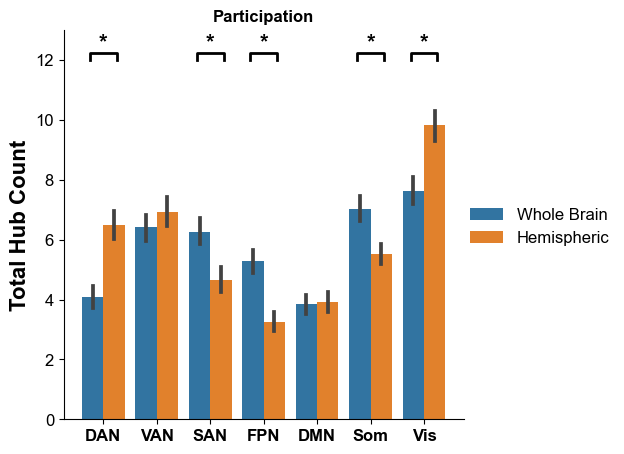

In [28]:
data = np.zeros((97 * 2 * 7, 1))
data[:,0] = np.hstack([contingency[str(i)][0, 0, :] for i in range(7)] + [contingency[str(i)][1, 0, :] for i in range(7)])

hubs = pd.DataFrame(data = data, columns = ['Counts'])
hubs['Measure'] = ['Participation'] * 97 * 14
hubs['Laterality'] = ['Whole Brain'] * 97 * 7 + ['Hemispheric'] * 97 * 7
hubs['Network'] = ['Dorsal Attention'] * 97 + ['Ventral Attention'] * 97 + ['Limbic'] * 97 + ['Frontoparietal'] * 97 + ['Default'] * 97 + ['Somatomotor'] * 97 + ['Visual'] * 97 + ['Dorsal Attention'] * 97 + ['Ventral Attention'] * 97 + ['Limbic'] * 97 + ['Frontoparietal'] * 97 + ['Default'] * 97 + ['Somatomotor'] * 97 + ['Visual'] * 97 

plot = sns.catplot(x = 'Network', y = 'Counts', col = 'Measure', hue = 'Laterality', kind = "bar", data = hubs)
plot._legend.set_title('')

axes = plot.axes
axes[0,0].set_title('Participation', fontweight = 'bold')
axes[0,0].set_xticklabels(network_abbrev, fontweight = 'bold', rotation = 0)
axes[0,0].set_xlabel('', fontweight = 'bold')
axes[0,0].set_ylim(0, 13)

for j, net in enumerate(network_names):
    hemispheric = hubs[(hubs['Measure'] == 'Participation') & (hubs['Laterality'] == 'Hemispheric') & (hubs['Network'] == net)]
    whole_brain = hubs[(hubs['Measure'] == 'Participation') & (hubs['Laterality'] == 'Whole Brain') & (hubs['Network'] == net)]
    p_value = scipy.stats.wilcoxon(hemispheric['Counts'], whole_brain['Counts'])[1]
    if p_value < 0.01:
        add_significance_bars(axes[0,0], p_value, j)
axes[0,0].set_ylabel('Total Hub Count', fontweight = 'bold')

In [29]:
for j, net in enumerate(network_names):
    hemispheric = hubs[(hubs['Measure'] == 'Participation') & (hubs['Laterality'] == 'Hemispheric') & (hubs['Network'] == net)]
    whole_brain = hubs[(hubs['Measure'] == 'Participation') & (hubs['Laterality'] == 'Whole Brain') & (hubs['Network'] == net)]
    print(f'{net}\n', scipy.stats.wilcoxon(hemispheric['Counts'], whole_brain['Counts']), f'\n')

Dorsal Attention
 WilcoxonResult(statistic=425.5, pvalue=5.7060099882675785e-11) 

Ventral Attention
 WilcoxonResult(statistic=1186.5, pvalue=0.052614925455580906) 

Limbic
 WilcoxonResult(statistic=707.0, pvalue=4.803137931422395e-07) 

Frontoparietal
 WilcoxonResult(statistic=320.5, pvalue=1.9608128649925432e-11) 

Default
 WilcoxonResult(statistic=1345.5, pvalue=0.8191110283718356) 

Somatomotor
 WilcoxonResult(statistic=451.5, pvalue=2.7917449899551225e-08) 

Visual
 WilcoxonResult(statistic=475.5, pvalue=5.897803810712547e-10) 



Lastly, we check the distributions of important Hm and WB regions across various resting state networks. Resting state is the spontaneous activity that occurs when someone is not engaging in any activity. Resting state networks are grouping of regions based on resting state activity. Because resting state networks have been associated with all sorts of phenomena, ranging from age to working memory, this analysis helps to understand some of the functional properities of important regions. In addition, it also reveals areas that are more resistant to lesions if the hypothesis is true.

We counted the number of important Hm and WB regions in each resting state network and compared across the two coefficients. Because each subject has individual Hm and WB coefficients for each region, the counts of important regions are aggregated and the distributions tested for statistical differences. We found several networks that show significant differences and is largely consistent with the graph plot shown earlier.

### Section summary <a name="section_0_3"></a>

# Hemispheric participation coefficients significantly predict the functional correlation between homotopic regional pairs. <a name="section_1"></a>

The previous analyses conffirmed that the Hemispheric (Hm) coefficient is indeed distinct from the Whole-Brain (WB) coefficient. However, these prior investigations primarily concentrated on low-level phenomena, which are somewhat detached from the behavioral outcomes associated with long-term recovery. Thereforce, this section contains analyses to associate the Hm coefficient with higher-level phenomena related to cognition.

One hypothesis, derived from the inter-hemispheric interactions captured by the Hm coefficient, suggests that the Hm coefficient should scale with the laterality of functional activity. That is, functional activities can be localized to various regions. Some functions, like language processing and spatial cognition, are predominantly localized to the left hemisphere, while others such as working memory are distributed across both hemispheres. Consequently, the Hm coefficients should be able to pinpoint regions that participate in these localized or distributed functions. This is due to the strong correlation between a region's associated functionality and the endpoints of the incoming and outgoing connections. Therefore, regions involved in processing within-hemisphere functions are more likely to form connections with other regions within the same hemisphere. In contrast, regions involved in processing functions distributed across hemispheres are more likely to maintain distributed connections. This then suggests that important Hm regions are more likely to engage in distributed functions compared to unimportant regions.

Capturing the distribution of functional activity presents a significant challenge. However, we employed a proxy approach utilizing NeuroSynth, an open-access dataset obtained from meta-analyses of tens of thousands of scientific publications. This resource compiles 3D coordinates from these studies to generate activity maps related to specific research topics. Consequently, for each topic or term, a map is created showing all the activity loci. I made use of these maps, encompassing over 490 topics and terms, to capture the broad spectrum of potential functions a region might participate in. This process yields a list of functional activities, which can serve as a basis for relating the Hm coefficient to the similarity of activity between homotopic regions.

### Section Specific Utility + Plotting Functions <a name="section_1_0"></a>

In [ ]:
def read_term_list(path):
    with open(path, 'r') as f:
        terms = f.read().splitlines()
    return terms

# Used to load and process the NeuroSynth images
def process_images(term_list, parcellation):
    parcel = {}
    voxels = np.zeros((590, (91 * 109 * 91)))

    for i, term in enumerate(term_list):
        images_data = load_nii_to_array(f'./NeuroSynth/{term}/{term}_association-test_z_FDR_0.01_FWHM_6.nii.gz')
        parcel[term] = {str(roi): np.mean(images_data[parcellation == roi]) for roi in range(246)}
        voxels[i, :] = images_data.flatten()
    
    return voxels, parcel

# Calculates and returns the loadings for each voxel and parcel
def get_loadings(voxels, parcellation):
    parcels_loading = {}
    
    pca = decomposition.PCA()
    pca.fit(voxels)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_T = loadings.T

    pc_values = np.arange(pca.n_components_) + 1
    plt.plot(pc_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

    for pc in range(590):
        reshape = np.reshape(loadings_T[pc,:], (91, 109, 91))
        parcels_loading[str(pc)] = {str(roi): np.mean(reshape[parcellation == roi]) for roi in range(246)}
    
    return loadings, parcels_loading

# Conduct OLS regression
def perform_ols(df, conditions, formula=None):
    for condition in conditions:
        subset = df[eval(condition)]
    if formula:
        est = smf.ols(formula=formula, data=subset).fit()
        print(est.summary())
    else:
        X = sm.add_constant(subset['Degree'])
        y = subset['Networked_Laterality']
        est = sm.OLS(y, X).fit()
        print(est.summary())
    return est.resid

In [31]:
# Plot the loadings onto a glass brain
def plot_brain(loadings_T, axes,):
    reference = load_img('./NeuroSynth/acoustic/acoustic_association-test_z_FDR_0.01_FWHM_6.nii.gz')
    
    for i, ax in enumerate(axes):
        reshaped_loading = np.reshape(loadings_T[i,:], (91, 109, 91))
        # reshaped_loading = nib.Nifti1Image(reshaped_loading, reference.affine)
        reshaped_loading = new_img_like(reference, reshaped_loading)

        plotting.plot_glass_brain(reshaped_loading,
                                  title = ('PC' + str(i + 1)),
                                  display_mode = 'yz',
                                  threshold = None,
                                  annotate = False,
                                  axes = ax)    

# Plot the Minkowski on the surface
def plotting_minkowski_surfaces(data):
    gifti_label = read_gifti_label('../../MRtrix3_connectome/BN_Atlas_freesurfer/fsaverage/32k/fsaverage.R.BN_Atlas.32k_fs_LR.label.gii')
    gifti_label = update_gifti_label(data, gifti_label)

    for i, r in enumerate(data):
        
        indices = np.where(gifti_label == i * 2)
        gifti_label[indices] = r
    
    fig, axs = plt.subplots(1, 2, figsize = (10, 6))
    fig.subplots_adjust(hspace = 0.0001, wspace = 0.0001)
    axs = axs.ravel()

    for subplot, ax in enumerate(axs):
        cmap = copy.copy(plt.get_cmap('viridis'))
        cmap.set_bad('dimgray')
        cmap.set_under('dimgray')

        view = 'medial' if subplot in [1] else 'lateral'
        
        ax.remove()
        ax = fig.add_subplot(1, 2, subplot + 1, projection = '3d')

        plotting.plot_surf_roi(surf_mesh=hcp.mesh.inflated_left,
                           roi_map=gifti_label,
                           hemi='left', 
                           view=view,
                           bg_map=hcp.mesh.sulc_left,
                           bg_on_data=True,
                           darkness=.2,
                           cmap=cmap,
                           cbar_tick_format='%.2g',
                           colorbar=True,
                           axes=ax,
                           vmin=np.min(data), vmax=np.max(data))
    
    plt.show()


### Load data files and set variables <a name="section_1_2"></a>

In [ ]:
term_list = read_term_list('./NeuroSynth/terms.txt')


## Analyses <a name="section_1_2"></a>

We load all the NeuroSynth maps for 490+ topics and run PCA on it. This was necessary to reduce the number of dimension of all the functions being studied since some of the topic maps might overlap. Because the topic terms are unfiltered, there could be separate maps for 'gambling' and 'games of chance'. Both would activate the same region but would be overrepresented in our data.

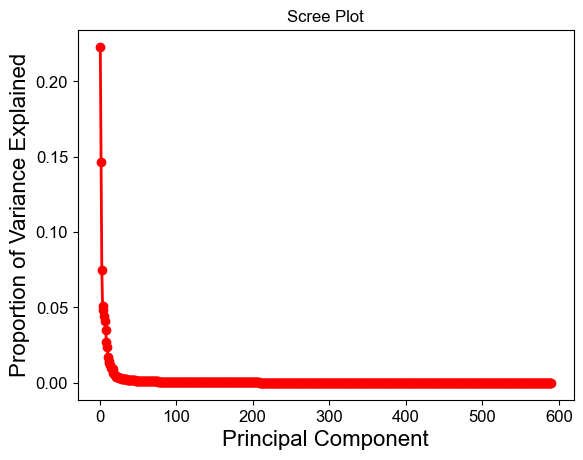

In [32]:
voxels, parcel = process_images(term_list, parcellation)
voxel_loadings, parcels_loading = get_loadings(voxels, parcellation)


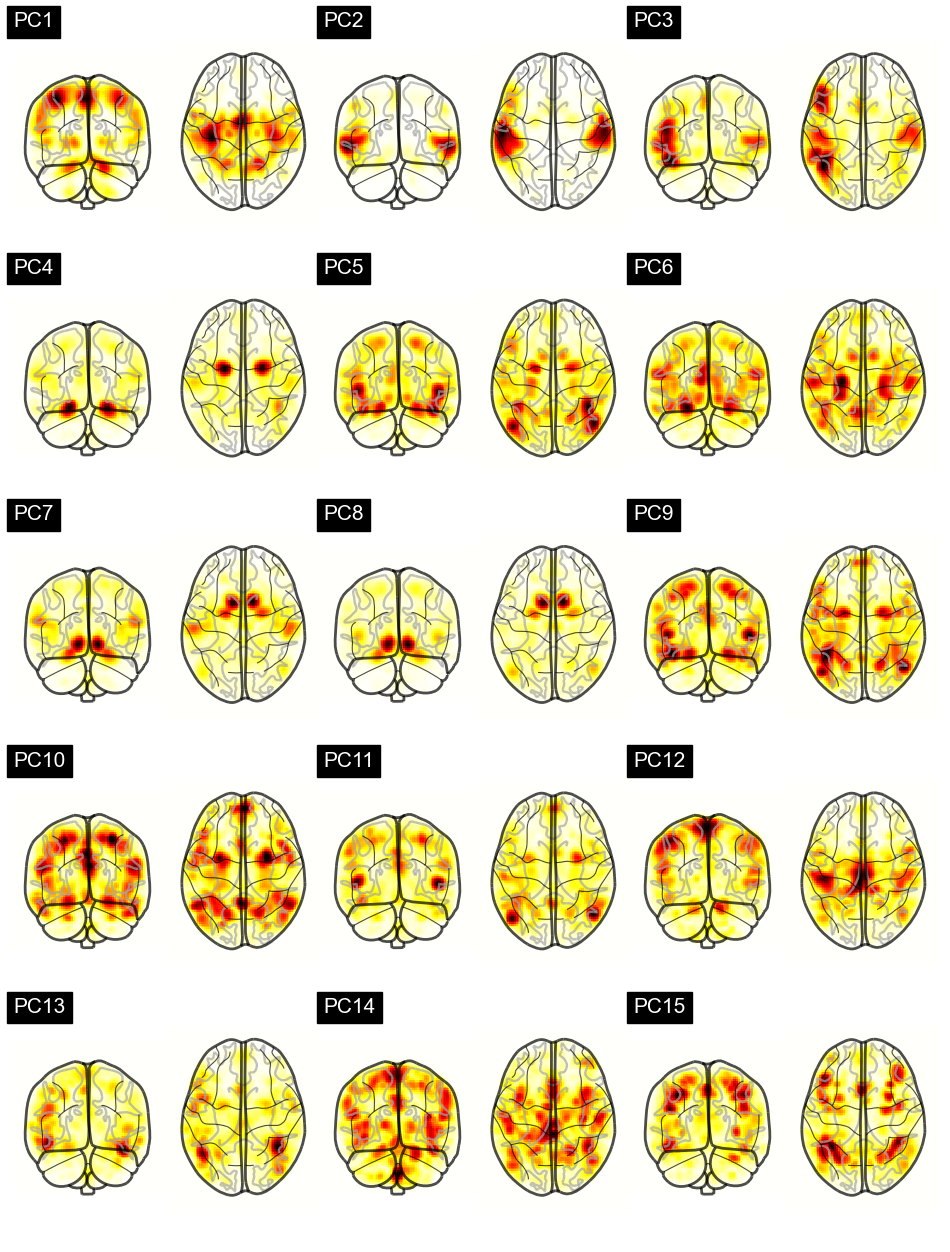

In [33]:
fig, axes = plt.subplots(5, 3, figsize = (12, 16))
fig.subplots_adjust(wspace = 0, hspace = 0)
axes = axes.ravel()

plot_brain(voxel_loadings.T, axes)
plt.subplots_adjust()
plt.show()

We projected the loadings from each PC onto a cartoon brain. This shows the relative activity represented by each PC. Though I don't make any claims as to what function/s each PC represents, some are clear like PC3 seems related to language. While we ended up with 490 PCs, I selected the first 15 based on visual inspection of the loadings and the Scree plot seen above. 

Once the PC loadings are obtained the activity between homotopic pairs are evaluated for similarity. Homotopic pairs are selected because comparing the activities of both regions is a good indicator of whether each region engages in cross-hemispheric functions. If both regions show similar profiles then the functions they engage in are likely to be found in both hemispheres. The inverse is also true. This assumption isn't always the case but remains a reliable measure for the majority of the cortex. 

We also need to select a measure of comparing the two activities. Because the activity can be sparse, Pearson's correlation wasn't a good indication of correlation between the two regions. Having tried several measures as well as designing some custom measures I found that the Manhattan distance revealed a similarity most aligned with my expectations. 

In [34]:
distance = np.zeros((2, 123))

for i, roi in enumerate(range(0, 246, 2)):
    homotopic = np.array([
        [parcels_loading[str(j)][str(k)]
         for j in range(15)]
        for k in [roi, roi + 1]
    ])

    distance[0, i] = scipy.spatial.distance.minkowski(homotopic[0], homotopic[1], p=1)

    minkowski = pd.DataFrame({
        'Loading': np.concatenate(homotopic),
        'PC': list(range(1, 16)) * 2,
        'Hemisphere': ['Left'] * 15 + ['Right'] * 15
    })

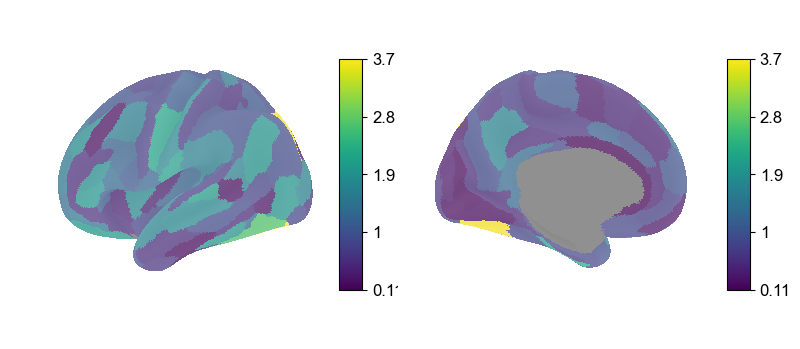

In [35]:
plotting_minkowski_surfaces(distance[0])

The Minkowski distance projected onto the cortical surface. Only a single hemisphere is shown has the distance to applicable to be both homotopic pairs. Decrease distance implies similar functional activity. Shortest distances are concentrated along the midline which is consistent with the results from the previous section.

In [70]:
data = np.hstack((participation_coef['normal'], participation_coef['lateral']))

df = pd.DataFrame(data = data, columns = ['Networked_Laterality'])

G = nx.convert_matrix.from_numpy_array(m_connectome)
df['Degree'] = np.tile(np.array(list(nx.degree(G)))[:,1], 2)

df['Measure'] = ['Participation'] * 420
df['Hemisphere'] = ['Left', 'Right'] * 210
df['Laterality'] = ['Normal'] * 210 + ['Lateral'] * 210
df['Functional_Laterality'] = np.tile(distance[0, :105], 4)
df['Covariate'] = np.tile(participation_coef['normal'], 2)

unimodal_indices = np.array([8, 9, 52, 53, 56, 57, 58, 59, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 
                           104, 105, 106, 107, 110, 111, 112, 113, 118, 119, 130, 131, 134, 135, 
                           144, 145, 148, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 161, 
                           162, 163, 170, 171, 180, 181, 188, 189, 190, 191, 192, 193, 194, 195, 
                           196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209])
unimodal_indices = np.hstack((unimodal_indices, unimodal_indices + 210))
multimodal_indices = np.setdiff1d(range(420), unimodal_indices)

unidmodal_df = df.iloc[unimodal_indices]
multimodal_df = df.iloc[multimodal_indices]

In [71]:
conditions_formulas = [
    (("df['Laterality'] == 'Lateral'",), None)
]

for conditions, formula in conditions_formulas:
    unimodal_regressed = perform_ols(unidmodal_df, conditions, formula)

for conditions, formula in conditions_formulas:
    multimodal_regressed = perform_ols(multimodal_df, conditions, formula)


                             OLS Regression Results                             
Dep. Variable:     Networked_Laterality   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                 -0.007
Method:                   Least Squares   F-statistic:                    0.4951
Date:                  Fri, 09 Jun 2023   Prob (F-statistic):              0.484
Time:                          15:40:28   Log-Likelihood:                 62.170
No. Observations:                    74   AIC:                            -120.3
Df Residuals:                        72   BIC:                            -115.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0393      0.037

I used OLS regression to evaluate the relationship between the Hm coefficient and Minkowski distance between unimodal and multimodal areas. Unimodal areas are regions classically thought to focus on a single modality like vision, audtion, or motor. Multimodal areas are regions that integrate these sensory regions and are closely related to cognition. Unimodal and multimodal regions also have distinct homotopic relationships that might impact our analysis. Because we focus on higher-level behavior, the multimodal analyses are of more interest than the unimodal analyses. Unimodal and multimodal regions were split according to each region's resting state network. 

The OLS regression results seems to be largely consistent with these expectations as the Minkowski distances of multimodal regions could be significantly predicted whereas the unimodal areas can not. Prior to this analysis we also checked for assumptions (using R cause its way easier) and found the assumptions to generally hold. 

Text(38.09375, 0.5, 'Minkowski\nDistance')

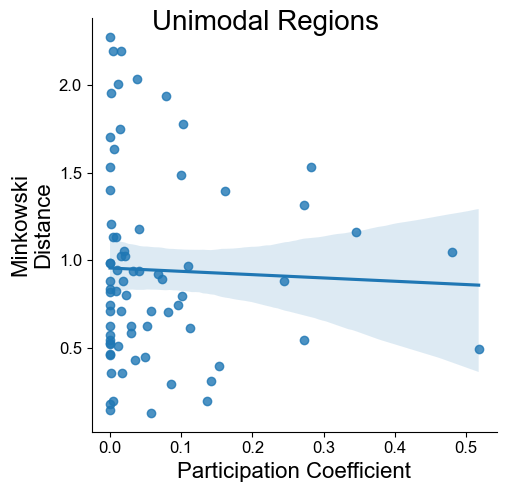

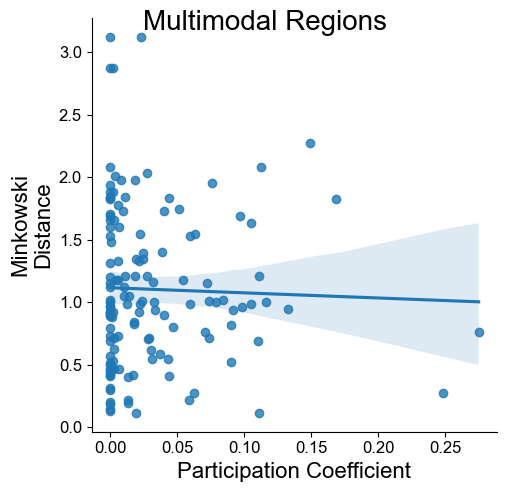

In [72]:
plot = sns.lmplot(x = "Networked_Laterality", y = "Functional_Laterality", data = unidmodal_df[(unidmodal_df['Laterality'] == 'Lateral')], sharex = False, sharey = True)

plot.fig.suptitle('Unimodal Regions')
plot.axes[0,0].set_xlabel('Participation Coefficient')
plot.axes[0,0].set_ylabel('Minkowski\nDistance')

plot = sns.lmplot(x = "Networked_Laterality", y = "Functional_Laterality", data = multimodal_df[(multimodal_df['Laterality'] == 'Lateral')], sharex = False, sharey = True)

plot.fig.suptitle('Multimodal Regions')
plot.axes[0,0].set_xlabel('Participation Coefficient')
plot.axes[0,0].set_ylabel('Minkowski\nDistance')


Plots of the Minkowski distance against the Hm coefficients for unimodal and multimodal regions.

### Section summary <a name="section_1_3"></a>

# Hemispheric participation coefficient can significantly predict scores on the Math but not the Story task <a name="section_2"></a>

Previous results have indicated that Hm coefficients can successfully predict the functional lateralization of multimodal regions. This suggests their relevance in understanding the potential behavioral impact post-lesion. But can we further improve this prediction? Is it possible to utilize these coefficients to predict task performance directly?

In this analysis, I attempted to predict performance on two distinct tasks - 'Math' and 'Story'. Considering language processing is predominantly lateralized to the left hemisphere and numerosity is distributed across both hemispheres, I hypothesize that the Hm coefficient should outperform the WB coefficient in predicting the 'Story' task performance. On the other hand, performance prediction for the 'Math' task could either remain similar or show a reversal in prediction accuracy. Hence, the 'Math' task acts as a control baseline to assess whether the Hm coefficients enhance prediction accuracy over the WB coefficients.

It's crucial to emphasize that, for this analysis, the relative prediction performance is of more significance than the absolute performance. However, considering this analysis is conducted at the individual level using subject-specific task scores and Hm/WB coefficients, if the results indicate that Hm coefficients can significantly predict task performance, it would strongly suggest the impact of Hm and WB coefficients on behavior.

### Section Specific Utility + Plotting Functions <a name="section_2_0"></a>

In [131]:
# Used to rescale the data
def prepare_data(data):
    data = data[:, features]
    data = np.log(np.add(data, np.abs(np.min(data[np.nonzero(data)])) + np.min(np.abs(data[np.nonzero(data)]))/2))
    return scaler.fit_transform(data)

# Function to predict the task score based on coefficients. Includes hyperparamter optimization loop inside.
def estimating_performance(measure, behavior, filter_indices, labels, filter_regions):
    cvo = KFold(n_splits=49, shuffle=True, random_state=42)
    RSME, correlation = [], []
    
    for train, tests in cvo.split(measure):
        X_train, X_tests = measure[train], measure[tests]
        y_train, y_tests = behavior[train], behavior[tests]

        scaler = preprocessing.StandardScaler()

        correlated = np.array([
            stats.pearsonr(X_train[:, i], y_train) if i in filter_indices and i not in filter_regions else [0, 0]
            for i in range(210)
        ])

        features = np.argsort(np.abs(correlated[:, 0]))[-5:]
        
        X_train = prepare_data(X_train)
        X_tests = prepare_data(X_tests)
        
        cvi = KFold(n_splits=4, shuffle=True, random_state=42)
        
        param_grid = {
            'layer_1': range(2, 13),
            'layer_2': range(2, 13),
            'layer_3': range(2, 13),
            'activation': ['relu' , 'tanh'],
            'alpha': (0.0001, 1),
            'momentum' : (0.5, 1.)
        }

        model_cv = RandomizedSearchCV(
            MLPWrapper_3(),
            param_grid,
            n_iter=2000,
            cv=cvi,
            scoring='neg_root_mean_squared_error',
            verbose=1, 
            n_jobs=-1, 
        )
                
        best_model = model_cv.fit(X_train, y_train).best_estimator_
        yhat = best_model.predict(X_tests)

        RSME.append(mean_squared_error(y_tests, yhat, squared=False))
        correlation.append(stats.spearmanr(y_tests, yhat)[0])

    return RSME, correlation

# Used to process loaded datasets containing results
def get_performance_measures(task_name, coef, behavior, indices, filter_regions):
    RMSE = {'lateral': np.zeros((1, 97)), 'normal': np.zeros((1, 97))}
    correlation = {'lateral': np.zeros((1, 2)), 'normal': np.zeros((1, 2))}

    for type in ['lateral', 'normal']:
        RMSE[type], correlation[type] = estimating_performance(
            coef[type],
            behavior[f'Language_Task_{task_name}_Avg_Difficulty_Level'],
            indices[task_name],
            f'{task_name}_{type}_participation',
            filter_regions
        )

    return RMSE, correlation



In [195]:
# Plot RMSE distributions
def plot_RMSE(data, bins, title):
    fig, ax = plt.subplots()
    
    for a in [data['lateral'], data['normal']]:
        plot = sns.distplot(a, bins=bins, ax=ax, kde=False)

    axes = plot.axes
    axes.set_title(title)
    axes.set_xlabel("RMSE")
    axes.set_ylabel("Density")
    plot.legend(['Hemispheric', 'Whole-Brain'])

# Plot the predicted and estimated scores
def plot_predicted_vs_estimated(prediction_file, empirical_behavior, plot_title):
    predicted = pd.read_pickle(prediction_file)

    df = pd.DataFrame({
        'Empirical': np.repeat(behavior[empirical_behavior], 2),
        'Predicts': np.hstack((predicted['lateral'][4], predicted['normals'][4])),
        'Laterals': ['Hemispheric'] * 97 + ['Whole-Brain'] * 97
    })

    print('Correlation between predicted and empirical scores using Hm coefficients\n', scipy.stats.pearsonr(predicted['lateral'][4], behavior[empirical_behavior]))
    print('Correlation between predicted and empirical scores using WB coefficients\n', scipy.stats.pearsonr(predicted['normals'][4], behavior[empirical_behavior]))
    
    plot = sns.lmplot(data=df, x="Empirical", y="Predicts", hue="Laterals", sharey=False)
    plot._legend.set_title('')

    axes = plot.axes
    axes[0,0].set_title(plot_title)
    axes[0,0].set_xlabel("Empirical Scores")
    axes[0,0].set_ylabel("Predicted Scores")

### Multilayer Perceptron Parameters <a name="section_2_1"></a>

In [133]:
class MLPWrapper_3(BaseEstimator, RegressorMixin):
    
    def __init__(self, layer_1 = 10, layer_2 = 10, layer_3 = 10, activation = 'relu', alpha = 0.0001, learning_rate_init = 0.001, momentum = 0.9):
        self.layer_1 = layer_1
        self.layer_2 = layer_2
        self.layer_3 = layer_3
        self.activation = activation
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.momentum = momentum

    def fit(self, X, y):
        model = MLPRegressor(
            hidden_layer_sizes = [self.layer_1, self.layer_2, self.layer_3],
            activation = self.activation,
            alpha = self.alpha,
            learning_rate = 'adaptive',
            learning_rate_init = self.learning_rate_init,
            solver = 'sgd',
            momentum = self.momentum,
            early_stopping = True,
            random_state = 42, 
            max_iter = 500, 
            n_iter_no_change = 20
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)


### Load data files and set variables <a name="section_2_2"></a>

In [134]:
with open('./s900_unrelated.txt') as file:
    subjects = np.array(file.read().splitlines()[0:97]).astype(int)

filter_regions = [52,  53,  55,  56,  59,  67,  75,  90,  94,  95,
   96,  97,  98,  99,  100, 101, 102, 103, 104, 4, 
   26,  28,  29,  32,  33,  35,  36,  37,  65,  72,
   74,  77,  78,  79,  80,  81,  85]

tasks = ['Language_Task_Story_Avg_Difficulty_Level',
         'Language_Task_Math_Avg_Difficulty_Level',
        ]

behavior = pd.read_csv('../../unrestricted_sec036_8_13_2020_2_27_32.csv')
behavior = behavior[behavior.Subject.isin(subjects)][tasks]

behavior = behavior.rename(columns={"Language_Task_Story_Avg_Difficulty_Level": "Language_Task_STORY_Avg_Difficulty_Level",
                                    "Language_Task_Math_Avg_Difficulty_Level": "Language_Task_MATHS_Avg_Difficulty_Level"})

with open('./tasks_indices.pkl', 'rb') as fp:
    tasks_index = pickle.load(fp)

tasks_index['MATHS'] = tasks_index.pop('MATH')


## Analysis <a name="section_2_3"></a>

We use a 3-layer multilayer perceptron (MLP) in order to predict the both scores using the Hm and WB coefficients. Because I didn't have prior experience using MLPs and there's no a priori required parameters I used a series of nested cross-validation to optimize the hyper-parameters and estimate the architecture. Optimization occured using randomized search. I used nested cross-validation to ensure absolutely no leaking of information across the training, validation, and test set. The parameters of the MLP are determined in the above section titled 'Multilayer Perceptron Parameters'. This step outputs ```MATHS_RMSE, MATHS_correlation, STORY_RMSE, STORY_correlation``` corresponding to the loss function (RMSE) and an intuitive estimate of performance (correlation).

In [ ]:
MATHS_RMSE, MATHS_correlation = get_performance_measures(
    'MATHS', participation_coef, behavior, tasks_index, filter_regions
)

STORY_RMSE, STORY_correlation = get_performance_measures(
    'STORY', participation_coef, behavior, tasks_index, filter_regions
)


Because going through all the hyper-parameters takes days and I just made this notebook for the assignment, I'm loading the pre-calculated estimates. 

In [135]:
with open('./models/STORY_5_MLPRegressor_PPE_49_folds_3_layers.pkl', 'rb') as fp:
    STORY_5_MLPRegressor_PPE_49_folds_3_layers = pickle.load(fp)

with open('./models/MATHS_5_MLPRegressor_PPE_49_folds_3_layers.pkl', 'rb') as fp:
    MATHS_5_MLPRegressor_PPE_49_folds_3_layers = pickle.load(fp)


STORY_RMSE = {'normal': None, 'lateral': None}
STORY_RMSE['normal'] = STORY_5_MLPRegressor_PPE_49_folds_3_layers['normals']['rmse']
STORY_RMSE['lateral'] = STORY_5_MLPRegressor_PPE_49_folds_3_layers['lateral']['rmse']

MATHS_RMSE = {'normal': None, 'lateral': None}
MATHS_RMSE['normal'] = MATHS_5_MLPRegressor_PPE_49_folds_3_layers['normals']['rmse']
MATHS_RMSE['lateral'] = MATHS_5_MLPRegressor_PPE_49_folds_3_layers['lateral']['rmse']


Ultimately, we care about whether Hm or WB coefficients are better at modeling task scores. One method of statistically testing the performance of Hm and WB coefficients is to compare the loss at each cross-validation fold. Because I used 49 folds the RMSE distribution contains 49 entries. Conducting a permutation test between the RMSE distributions between Hm and WB estimates reveals if a statistical difference exists.

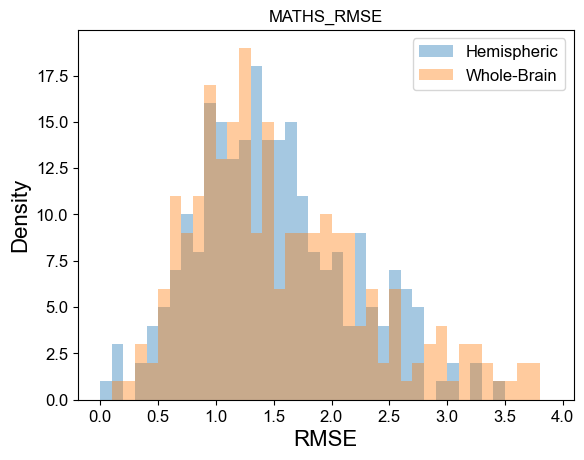

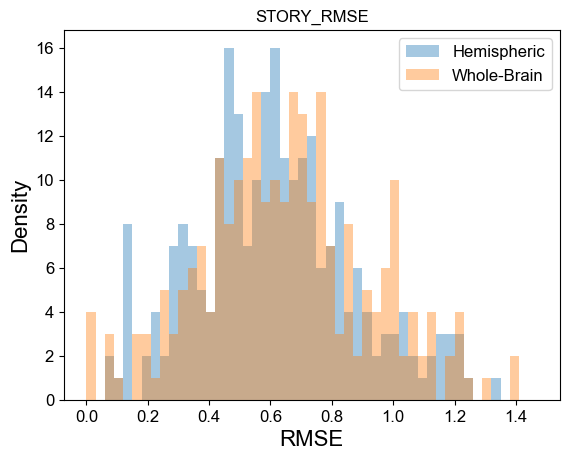

In [173]:
plot_sns_RMSE(MATHS_RMSE, np.arange(0, 4, 0.1), "MATHS_RMSE")
plot_sns_RMSE(STORY_RMSE, np.arange(0, 1.5, 0.03), "STORY_RMSE")

In [184]:
print('Math\n', scipy.stats.ttest_ind(MATHS_RMSE['lateral'][4], MATHS_RMSE['normal'][4]))
print('\nStory\n', scipy.stats.ttest_ind(STORY_RMSE['lateral'][4], STORY_RMSE['normal'][4]))


Math
 Ttest_indResult(statistic=-0.45137255859942815, pvalue=0.6527390796573493)

Story
 Ttest_indResult(statistic=-0.49250624816326016, pvalue=0.6234860214280791)


We statistically compared the RMSE distributions derived from modeling task scores using Hm and WB coefficients. Testing found the RMSE distributions are not significantly different between RMSE distributions on both Maths and Story tasks. In other words, the Hm coefficients are not any more informative about performance on the Math or Story tasks.

The above plots are created using cross-validation to get generalizable models. Below, predictions are generated using models overfit on all the available data. These plots are used to visualize the upper limit of performance on the MLP but should not be confused for performance were generalizability should be emphasized. In other words, the predictions are made by peaking at the testing data. However given the aggresive folds (2 samples in the test set and remaining in the training/validation set), actual generalizable performance is not far from what is found by overfitting. Though of course lower.

Correlation between predicted and empirical scores using Hm coefficients
 PearsonRResult(statistic=0.42454281017432477, pvalue=1.4648285394601968e-05)
Correlation between predicted and empirical scores using WB coefficients
 PearsonRResult(statistic=0.31384310090417245, pvalue=0.001745572372220179)


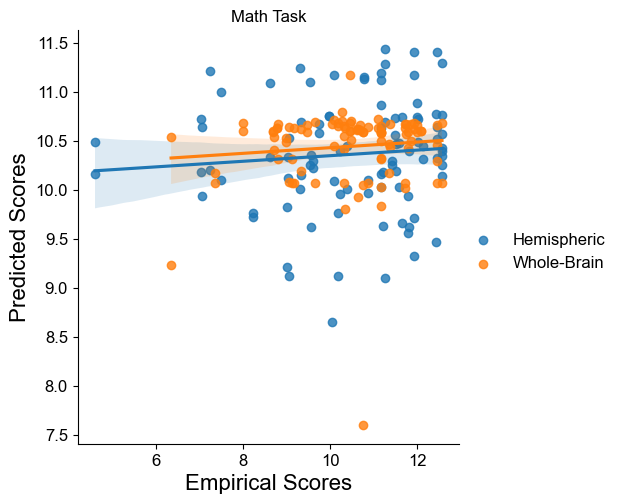

In [196]:
plot_predicted_vs_estimated('./models/MATHS_predicted.pkl', 'Language_Task_STORY_Avg_Difficulty_Level', 'Math Task')


Correlation between predicted and empirical scores using Hm coefficients
 PearsonRResult(statistic=0.17185157140770377, pvalue=0.09234667865426338)
Correlation between predicted and empirical scores using WB coefficients
 PearsonRResult(statistic=0.24186420722591945, pvalue=0.01699773249904464)


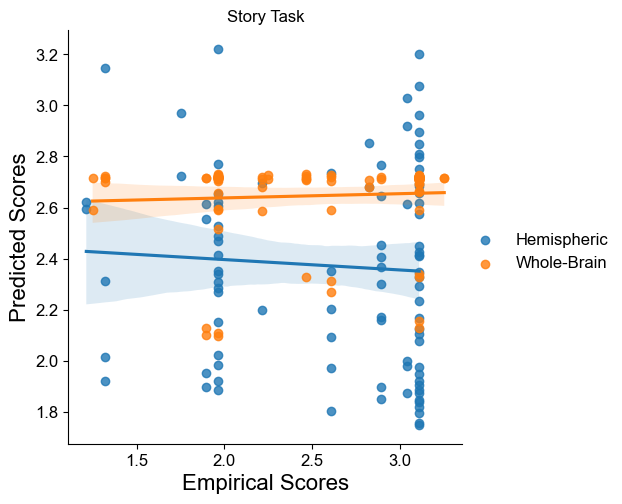

In [197]:
plot_predicted_vs_estimated('./models/STORY_predicted.pkl', 'Language_Task_MATHS_Avg_Difficulty_Level', 'Story Task')

### Section summary <a name="section_2_4"></a>

# Summary <a name="summary"></a>

Our analyses revealed several properties of the Hm coefficients that were aligned with our expectations and others that were not.

**Good news!**:
+ Hm and WB coefficients are distinct (un-correlated) from one another
+ Ranking regions according to Hm and WB coefficients found different subsets of high ranking regions
+ Ranking Hm regions reveals regions with more opposite hemisphere connections
+ Ranking Hm regions reveals regions that are closer to the opposite hemisphere
+ Hm coefficients predict regions that engage in localized or distributed processing for multimodal regions
+ Hm and WB coefficients can sort of predict scores on the Math task

**Bad news!**:
+ Hm coefficients do not predict regions that engage in localized or distributed processing for unimodal regions
+ Hm coefficients are not any better at predicting story performance compared to the WB coefficients
+ Hm and WB coefficients are mediocre at predicting scores on the Story task

# Trash <a name="trash"></a>

In [ ]:
def infomap_partiti(G):

    partition = np.zeros((1, 210))[0]
        
    infomapWrapper = infomap.Infomap("--two-level --silent")

    for e in G.edges(data = True):
        infomapWrapper.addLink(e[0], e[1], e[2]['weight'])

    infomapWrapper.run();

    for node, module in infomapWrapper.modules:
        partition[node] = module
    
    return partition

def participation_coefficient(G, module_partition):

    pc_dict = {}

    for m in module_partition.keys():
        M = set(module_partition[m])
                
        for v in M:
                        
            degree = float(nx.degree(G = G, nbunch = v))

            wm_degree = float(sum([1 for u in M if (u, v) in G.edges()]))

            if degree == 0.0 or degree == 0:
                pc_dict[v] = 0
            else:
                pc_dict[v] = 1 - ((float(wm_degree) / float(degree))**2)
    
    return pc_dict

In [ ]:
scaler = MinMaxScaler().fit(white_matter)
paths_length = -1 * np.log(scaler.transform(white_matter))
paths_length[np.isinf(paths_length)] = 0
    
G = {'whole' : nx.convert_matrix.from_numpy_array(white_matter), 'lefts' : nx.convert_matrix.from_numpy_array(white_matter), 'right' : nx.convert_matrix.from_numpy_array(white_matter)}
L = {'whole' : nx.convert_matrix.from_numpy_array(paths_length), 'lefts' : nx.convert_matrix.from_numpy_array(paths_length), 'right' : nx.convert_matrix.from_numpy_array(paths_length)}

for node in np.arange(1, 210, 2):
    G['lefts'].remove_node(node)
    L['lefts'].remove_node(node)
for node in np.arange(0, 210, 2):
    G['right'].remove_node(node)
    L['right'].remove_node(node)

### participation
partition = infomap_partiti(G['whole'])

modules = {}; lodules = {}; rodules = {}

for j, node in enumerate(partition):

    if str(node) in modules:
        modules[str(node)].append(j)
    else:
        modules[str(node)] = [j]

    if (str(node) in lodules) and (j in np.arange(0, 210, 2)):
        lodules[str(node)].append(j)
    elif j in np.arange(0, 210, 2):
        lodules[str(node)] = [j]

    if (str(node) in rodules) and (j in np.arange(1, 210, 2)):
        rodules[str(node)].append(j)
    elif j in np.arange(1, 210, 2):
        rodules[str(node)] = [j]

whole = participation_coefficient(G['whole'], modules)
lefts = participation_coefficient(G['lefts'], lodules)
right = participation_coefficient(G['right'], rodules)

participation_coef['normal'] = np.array(list(whole.values()))

for node in whole.items():
    if node[0] in np.arange(0, 210, 2):
        if np.abs([whole[node[0]] - lefts[node[0]]]) == 0:
            participation_coef['lateral'][node[0]] = 0 # np.nan
        else:
            participation_coef['lateral'][node[0]] = np.abs([whole[node[0]] - lefts[node[0]]])
    else:
        if np.abs([whole[node[0]] - right[node[0]]]) == 0:
            participation_coef['lateral'][node[0]] = 0 # np.nan
        else:
            participation_coef['lateral'][node[0]] = np.abs([whole[node[0]] - right[node[0]]])
